In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib
import numpy as np
from datascience import *
from datetime import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


RSF_Table = Table.read_table("scraped_data2.csv")
def convert_to_datetime(start):
     # converts the table to the datetime objects to better manipulate them
    return datetime.strptime(start, "%m/%d/%Y %H:%M")
convert = RSF_Table.apply(convert_to_datetime,'Timestamp')
#new = RSF_Table.apply(convert_to_datetime2,'Timestamp')
RSF_Table = RSF_Table.with_columns('Timestamp', convert).drop('Unnamed: 2')


#lets do Mondays, Lets do an A/B test testing if Mondays are statistically significant
#Step 0: make the data clean with the apropriate hours
#step 1, make a table of the average proportion full on that day
#

#CHANGE VARIABLES HERE TO SPECIFY TIME: CAHNGE MINUTES_CHANGE to the durration of the gym, and the int under start.hour< int for desired times, right now its under RSF hours but lets say if i didnt want to wake up early I would change the 6 to a 10  

def replace_day_of_week(day):
    day = day.weekday()# later i use the weekday() from datetime, for formatting purposes I want the day of the week to show on the table
    if day ==0:
        return 'Monday '
    if day ==1:
        return 'Tuesday '
    if day ==2:
        return 'Wednesday '
    if day ==3:
        return 'Thursday '
    if day ==4:
        return 'Friday '
    if day == 5:
        return 'Saturday '
    if day ==6:
        return 'Sunday '

def correct_hours(Table_element):   
    if Table_element.hour <22 and Table_element.weekday() != 5 and Table_element.weekday() != 6 and Table_element.hour > 7: # make sure its during rsf hours
        return Table_element
    if Table_element.hour <17 and Table_element.weekday() == 5 and Table_element.hour > 6: # make sure its during rsf hours
        return Table_element
    if Table_element.hour <22 and Table_element.weekday() == 6 and Table_element.hour > 7: # make sure its during rsf hours
        return Table_element
    return None

convert2 = RSF_Table.apply(replace_day_of_week,'Timestamp')
RSF_Table = RSF_Table.with_columns('Day', convert2)
convert = RSF_Table.apply(correct_hours,'Timestamp')
RSF_Table = RSF_Table.with_columns('Timestamp', convert).where('Timestamp',are.not_equal_to(None)).where('Data',are.above(0.0001))


Using matplotlib backend: agg


In [6]:
Observed_means = RSF_Table.group('Day',np.mean).drop('Timestamp mean')
Observed_Friday = Observed_means.item(0).column('Data mean')
Observed_Monday = Observed_means.item(1).column('Data mean')
Observed_Saturday = Observed_means.item(2).column('Data mean')
Observed_Sunday = Observed_means.item(3).column('Data mean')
Observed_Tuesday = Observed_means.item(5).column('Data mean')
Observed_Wednesday= Observed_means.item(6).column('Data mean')
Observed_Thursday= Observed_means.item(4).column('Data mean')


/opt/conda/lib/python3.9/site-packages/datascience/tables.py:222: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


In [7]:
## A/B Testing to see if the mean proportion for sunday is significantly different from the rest of the days
#Null: Sunday has the same proportion as any other day 
#Alt: Sunday has a different proportion then another day 

def sample_shuffle(RSF_Table):
    
    shuffled_labels = RSF_Table.sample(with_replacement = False).column('Day')
    shuffled = RSF_Table.with_column('Shuffled Day', shuffled_labels)
    return shuffled.group('Shuffled Day',np.mean).select('Shuffled Day','Data mean').column(1)



In [9]:
temp = make_array()

for i in np.arange(1000):
    sample = sample_shuffle(RSF_Table)[0]
    temp = np.append(temp,float(sample))
temp2 = Table().with_columns('sample',temp)

Day,Data mean,p_val
Friday,0.825879,0.893
Monday,0.856855,1
Saturday,0.774173,0
Sunday,0.645154,0
Thursday,0.864101,1
Tuesday,0.820474,0.704
Wednesday,0.846676,1


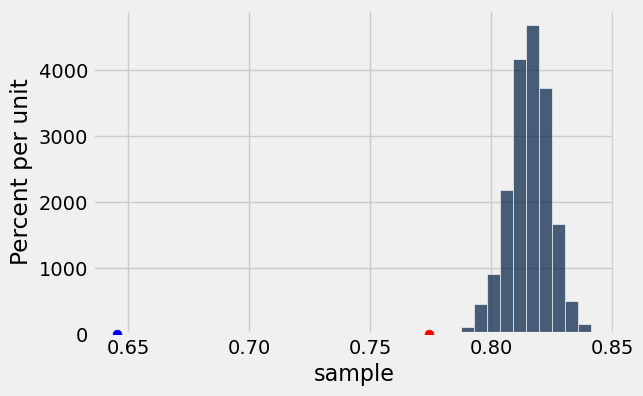

In [10]:
temp2.hist('sample')
plots.scatter(Observed_Saturday, 0, color='red', s=40, zorder=3)
plots.scatter(Observed_Sunday, 0, color='blue', s=40, zorder=3)



def p_value(value):
    return sum(value > temp)/1000


p_val_array = RSF_Table.group('Day',np.mean).apply(p_value,'Data mean')
RSF_Table.group('Day',np.mean).drop('Timestamp mean').with_columns('p_val',p_val_array)